<a href="https://colab.research.google.com/github/rkdwodms/Data-analysis/blob/main/KC_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# df.to_csv('KC_house.csv')
# from google.colab import files
# files.download('KC_house.csv')

In [2]:
from google.colab import drive
import pandas as pd
drive.mount('/gdrive')

# 데이터 불러오기

df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/data/KC_house.csv')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
!pip install --upgrade scikit-learn

In [5]:
df.columns
# df = df.drop(df.columns[0],axis = 1)

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
df.info()
#object 특성 파악 
df['date'] #datetime type으로 변경 
df['date'] = pd.to_datetime(df['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21613 non-null  int64  
 1   id             21613 non-null  int64  
 2   date           21613 non-null  object 
 3   price          21613 non-null  float64
 4   bedrooms       21613 non-null  int64  
 5   bathrooms      21613 non-null  float64
 6   sqft_living    21613 non-null  int64  
 7   sqft_lot       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   waterfront     21613 non-null  int64  
 10  view           21613 non-null  int64  
 11  condition      21613 non-null  int64  
 12  grade          21613 non-null  int64  
 13  sqft_above     21613 non-null  int64  
 14  sqft_basement  21613 non-null  int64  
 15  yr_built       21613 non-null  int64  
 16  yr_renovated   21613 non-null  int64  
 17  zipcode        21613 non-null  int64  
 18  lat   

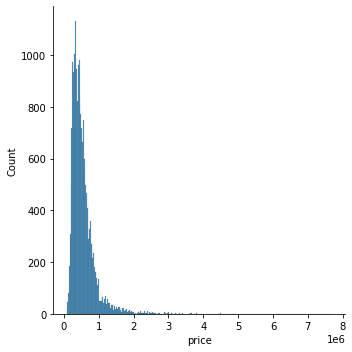

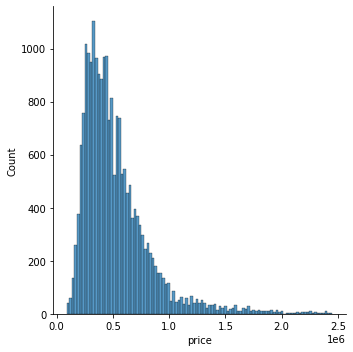

In [7]:
#타겟값 outlier 제거 : 상위 하위 5% 제거
sns.displot(df['price'])

df = df[(df['price'] >= np.percentile(df['price'], 0.05)) & 
        (df['price'] <= np.percentile(df['price'], 99.5))]

sns.displot(df['price'])

In [8]:
# 데이터 split
cutOff = pd.to_datetime('2015-03-01')
train = df[df['date'] < cutOff]
test  = df[df['date'] >= cutOff]

In [9]:
train.shape, test.shape

((16772, 22), (4721, 22))

In [10]:
#특성 엔지니어링 : 총 방수, 미사용 특성 제거

def engineer_features(X):

    # pandas.DataFrame.copy()
    X = X.copy()
    
    ## 욕실 갯수을 정수형으로 처리합니다.
    X['bathrooms'] = X['bathrooms'].round(0).astype(int)

    ## 총 방 수를 합하여 rooms로 합쳐 봅시다.
    X['rooms'] = X['bedrooms'] + X['bathrooms']


    ## 사용하지 않을 특성을 삭제합니다.
    X = X.drop(['id', 'date', 'waterfront'],axis=1)

    return X

train = engineer_features(train)
test = engineer_features(test)

In [11]:
target = 'price'

## X_train, y_train, X_test, y_test 데이터로 분리
X_train = train.drop(columns=target)
y_train = train[target]

X_test = test.drop(columns=target)
y_test = test[target]

In [12]:
# target(Price)와 가장 correlated 된 features 를 k개 고르는 것이 목표입니다.

## f_regresison, SelectKBest
from sklearn.feature_selection import f_regression, SelectKBest

## selctor 정의합니다.
selector = SelectKBest(score_func=f_regression, k=10)

## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train, y_train)

## 테스트 데이터는 transform
X_test_selected = selector.transform(X_test)


X_train_selected.shape, X_test_selected.shape

((16772, 10), (4721, 10))

In [13]:
all_names = X_train.columns

## selector.get_support()
selected_mask = selector.get_support()

## 선택된 특성들
selected_names = all_names[selected_mask]

## 선택되지 않은 특성들
unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['bedrooms', 'bathrooms', 'sqft_living', 'view', 'grade', 'sqft_above',
       'sqft_basement', 'lat', 'sqft_living15', 'rooms'],
      dtype='object')
Unselected names:  Index(['Unnamed: 0', 'sqft_lot', 'floors', 'condition', 'yr_built',
       'yr_renovated', 'zipcode', 'long', 'sqft_lot15'],
      dtype='object')


1 features
Selected names:  Index(['sqft_living'], dtype='object')
Test MAE: $167,321
Test R2: 0.4296149194220933 

2 features
Selected names:  Index(['sqft_living', 'grade'], dtype='object')
Test MAE: $157,239
Test R2: 0.4884712916259375 

3 features
Selected names:  Index(['sqft_living', 'grade', 'sqft_living15'], dtype='object')
Test MAE: $156,951
Test R2: 0.49204137332086406 

4 features
Selected names:  Index(['sqft_living', 'grade', 'sqft_above', 'sqft_living15'], dtype='object')
Test MAE: $154,920
Test R2: 0.5019286655041768 

5 features
Selected names:  Index(['bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15'], dtype='object')
Test MAE: $154,979
Test R2: 0.5020209934516052 

6 features
Selected names:  Index(['bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15',
       'rooms'],
      dtype='object')
Test MAE: $154,376
Test R2: 0.505157284321 

7 features
Selected names:  Index(['bathrooms', 'sqft_living', 'view', 'grade', 'sqft_above',
       'sq

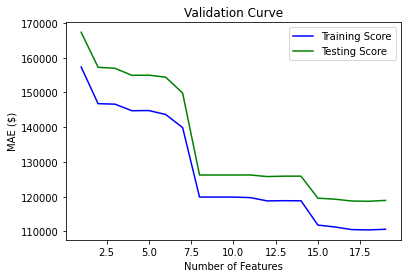

In [14]:
# features를 몇 개 선책하는 것이 좋은지 알아 봅시다.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

training = []
testing = []
ks = range(1, len(X_train.columns)+1)

# 1 부터 특성 수 만큼 사용한 모델로 MAE 값 비교.
for k in range(1, len(X_train.columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    all_names = X_train.columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(y_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    testing.append(mae)
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE ($)")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()

#18개 피처를 다 쓰는게 좋다는 뜻인가..?

Ridge Regression, alpha=0.001
Test MAE: $118,920
Test R2: 0.675


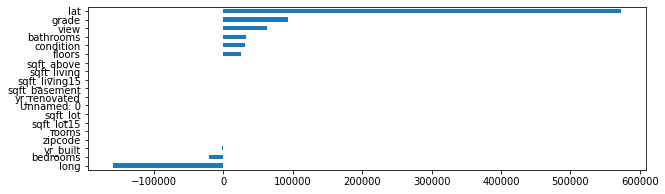

Ridge Regression, alpha=0.005
Test MAE: $118,825
Test R2: 0.675


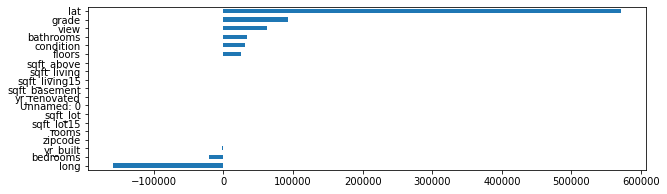

Ridge Regression, alpha=0.01
Test MAE: $118,713
Test R2: 0.675


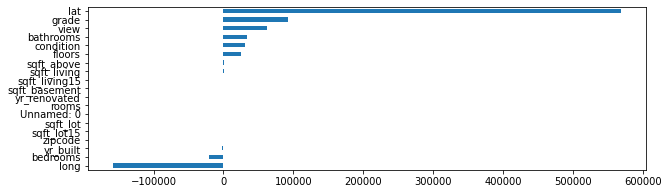

Ridge Regression, alpha=0.02
Test MAE: $118,516
Test R2: 0.675


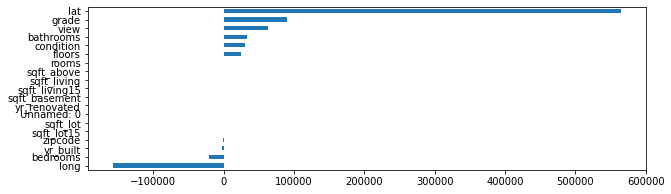

Ridge Regression, alpha=0.03
Test MAE: $118,348
Test R2: 0.674


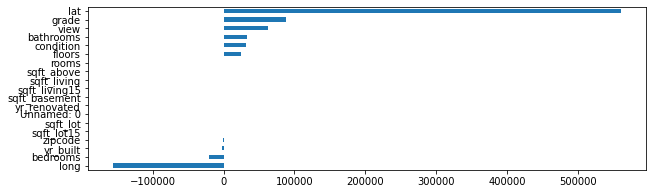

Ridge Regression, alpha=0.1
Test MAE: $117,656
Test R2: 0.670


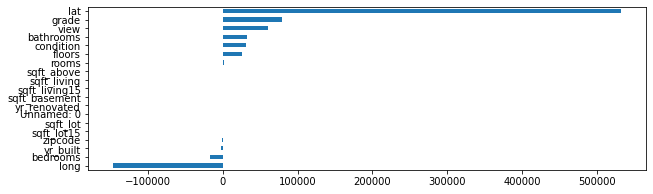

Ridge Regression, alpha=1.0
Test MAE: $127,535
Test R2: 0.594


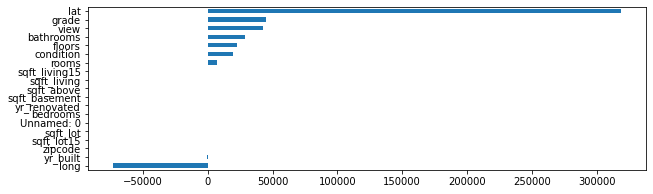

Ridge Regression, alpha=1
Test MAE: $127,535
Test R2: 0.594


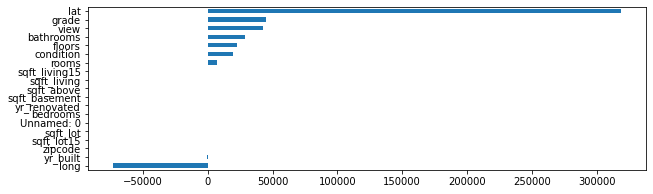

Ridge Regression, alpha=100.0
Test MAE: $211,820
Test R2: 0.044


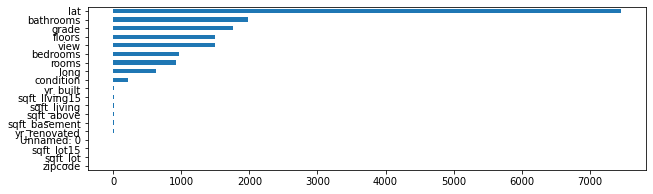

Ridge Regression, alpha=1000.0
Test MAE: $216,996
Test R2: 0.002


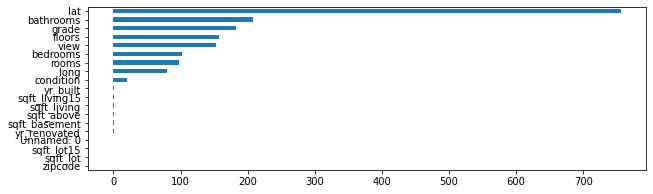

In [15]:
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score

for alpha in [0.001, 0.005, 0.01, 0.02, 0.03, 0.1, 1.0, 1, 100.0, 1000.0]:
        
    print(f'Ridge Regression, alpha={alpha}')

    # Ridge 모델 학습
    model = Ridge(alpha=alpha, normalize=True)  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # MAE for test
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2:,.3f}')
    
    # plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(10,3))
    coefficients.sort_values().plot.barh()
    plt.show()

In [16]:
X_total = pd.concat([X_train, X_test])
y_total = pd.concat([y_train, y_test])

In [17]:
!pip install delayed

In [20]:
# 최종모델
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def RidgeCVRegression(degree=3, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         RidgeCV(**kwargs))
alphas = np.arange(0.01, 0.2, 0.01)
    
model = RidgeCVRegression(alphas=alphas, normalize=True, cv=5)
model.fit(X_total, y_total)

coefs = model.named_steps["ridgecv"].coef_
print(f'Number of Features: {len(coefs)}')

print(f'alpha: {model.named_steps["ridgecv"].alpha_}')
# print(f'cv best score: {model.named_steps["ridgecv"].best_score_}')

coefs.sort()

Number of Features: 1540
alpha: 0.19


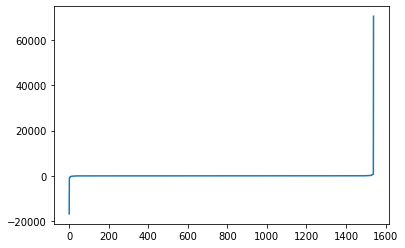

In [21]:
plt.plot(coefs)

In [27]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.19, normalize=True)
ridge.fit(X_train, y_train)

ridge.score(X_test,y_test)


0.6630292381256822

In [28]:
pred = ridge.predict(X_test)
pred

array([334734.94688806, 299962.25983214, 696895.11705388, ...,
       838453.82504676, 470275.34055396, 774310.51309933])